## Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras

from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
#defining hyperparameters
SIZE = 224
img_size = (SIZE,SIZE)
batch_size = 64


#images classes
classes = ['fifty','five','five hundred','hundred','ten','thousand','twenty']

#for data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    horizontal_flip=True,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   vertical_flip=True,                                   
                                   zoom_range = 0.2,
                                   )



# Creating training and testing sets
training_set = train_datagen.flow_from_directory('/kaggle/input/currency-my-one/folder/train',
                                                 target_size = img_size,
                                                 batch_size = batch_size,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

test_set = train_datagen.flow_from_directory('/kaggle/input/currency-my-one/folder/test',
                                            target_size = img_size,
                                            batch_size = 700,
                                             shuffle = True,
                                            class_mode = 'categorical')
valid_set = train_datagen.flow_from_directory('/kaggle/input/currency-my-one/folder/valid',
                                            target_size = img_size,
                                            batch_size = batch_size,
                                              shuffle = True,
                                            class_mode = 'categorical')

Found 12600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1750 images belonging to 7 classes.


## Visualizing our data

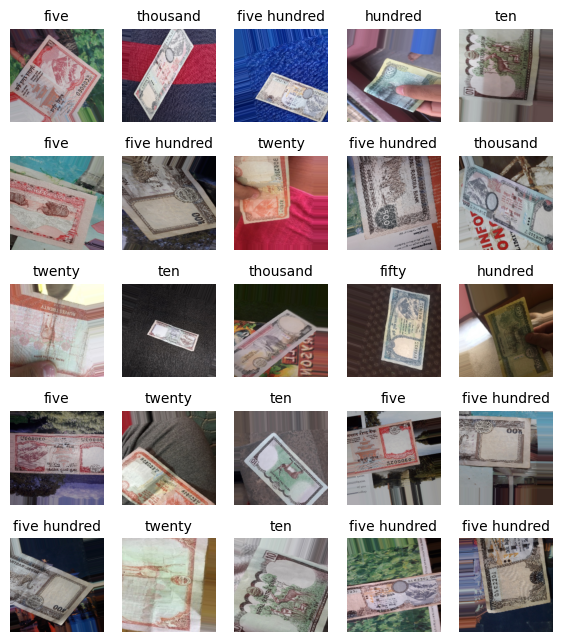

In [3]:
images,labels = next(iter(training_set))

def plot_images(data,label):
    plt.figure(figsize = (7,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.title(f'{classes[np.argmax(label[i])]}',fontsize =10)
        plt.imshow(data[i])
        plt.axis('off')

plot_images(images,labels)

## Defining our model

In [4]:
from tensorflow.keras.applications import VGG19


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False


model = keras.models.Sequential([
    base_model,
    layers.Conv2D(256,(3,3)),
    layers.LeakyReLU(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # Adjust the number of units based on your specific task
])

#compiling our model
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])
model.summary()


80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 256)         1179904   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 5, 256)         0         
                                                                 
 batch_normalization (Batch  (None, 5, 5, 256)         1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 5, 5, 256)         0         
                                                                 
 flatten (Flatten)           (None, 6400)              0 

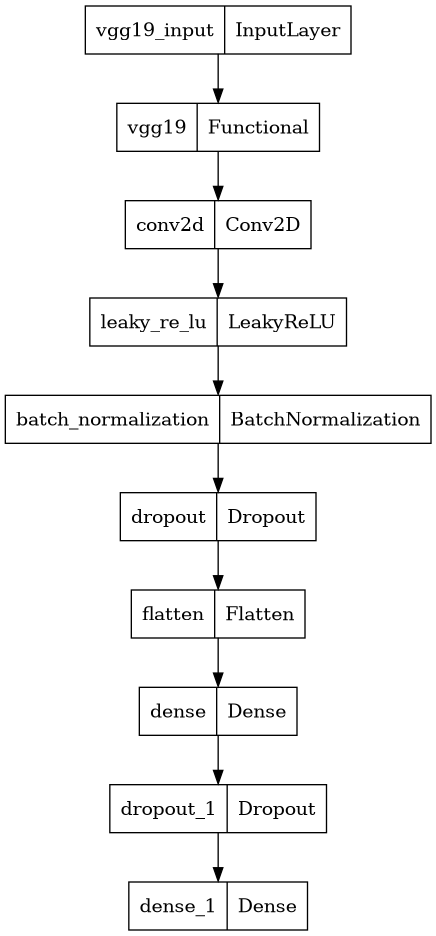

In [5]:
tf.keras.utils.plot_model(model,to_file = "model.png")

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_callback = ModelCheckpoint(filepath='final_model.h5', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4)


history = model.fit(training_set,epochs=20,validation_data = valid_set,callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/20


2023-12-05 06:51:32.622388: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


197/197 [==============================] - 375s 2s/step - loss: 0.7972 - accuracy: 0.7421 - val_loss: 2.1839 - val_accuracy: 0.5314
Epoch 2/20
197/197 [==============================] - 236s 1s/step - loss: 0.4316 - accuracy: 0.8582 - val_loss: 0.4642 - val_accuracy: 0.8651
Epoch 3/20
197/197 [==============================] - 236s 1s/step - loss: 0.3802 - accuracy: 0.8746 - val_loss: 0.6567 - val_accuracy: 0.8109
Epoch 4/20
197/197 [==============================] - 240s 1s/step - loss: 0.3542 - accuracy: 0.8829 - val_loss: 0.3461 - val_accuracy: 0.8966
Epoch 5/20
197/197 [==============================] - 235s 1s/step - loss: 0.3090 - accuracy: 0.8968 - val_loss: 0.3073 - val_accuracy: 0.9029
Epoch 6/20
197/197 [==============================] - 236s 1s/step - loss: 0.2792 - accuracy: 0.9098 - val_loss: 0.6671 - val_accuracy: 0.8457
Epoch 7/20
197/197 [==============================] - 234s 1s/step - loss: 0.2694 - accuracy: 0.9106 - val_loss: 0.5562 - val_accuracy: 0.8457
Epoch 8/20

1/1 [==============================] - 0s 19ms/step


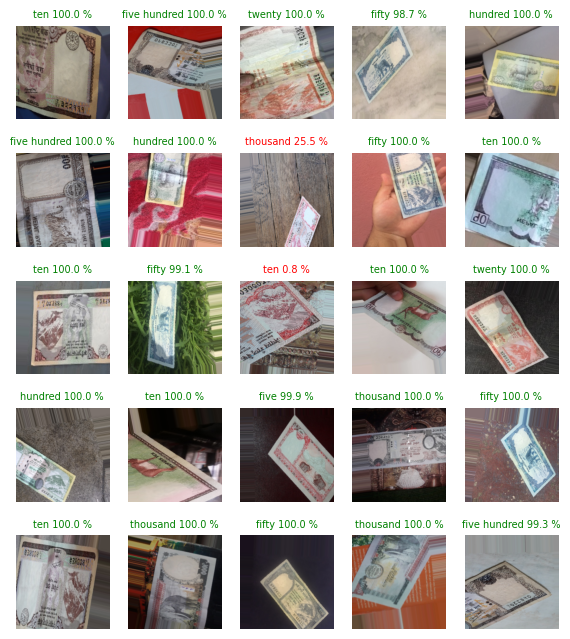

In [7]:
images,labels = next(iter(test_set))

def plot_images(data,label):
    plt.figure(figsize = (7,8))
    for i in range(25):
        plt.subplot(5,5,i+1)
        predicted = model.predict(np.array(data[i]).reshape(1,SIZE,SIZE,3))
        if np.argmax(label[i]) == np.argmax(predicted):
            color = 'green'
        else:
            color = 'red'
        plt.title(f'{classes[np.argmax(predicted)]} {np.round(predicted[0][np.argmax(label[i])] *100,1)} %',fontsize =7,color = color)
        plt.imshow(data[i])
        plt.axis('off')

plot_images(images,labels)

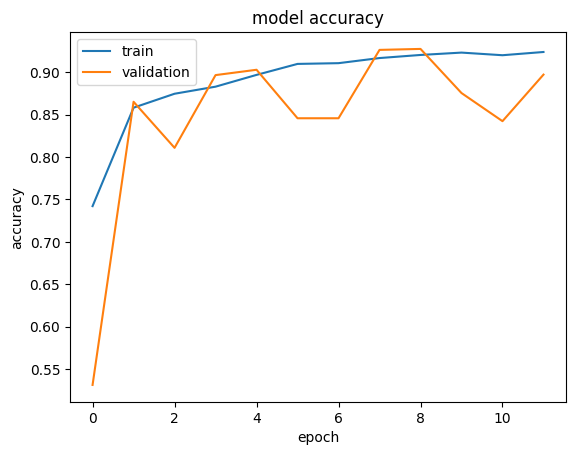

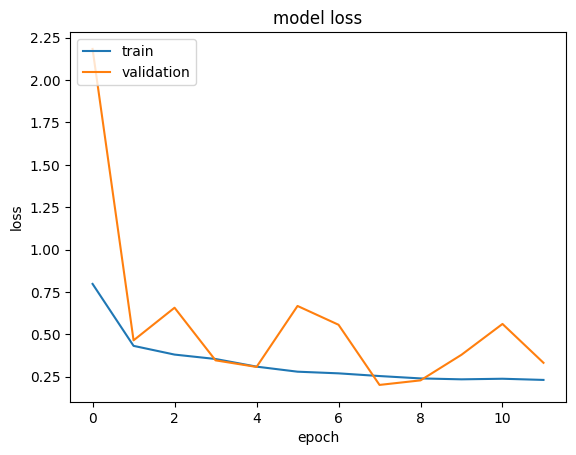

In [8]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Class Activation Map


In [9]:
'''Grad-CAM is a popular technique for visualizing where a convolutional neural network model is looking.'''

import matplotlib.cm as cm
from IPython.display import Image, display


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

   
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

  
    grads = tape.gradient(class_channel, last_conv_layer_output)

  
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

  
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Combining Heatmaps and Images
def display_gradcam(img_path, heatmap,cam_path = 'cam.jpg',  alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
    

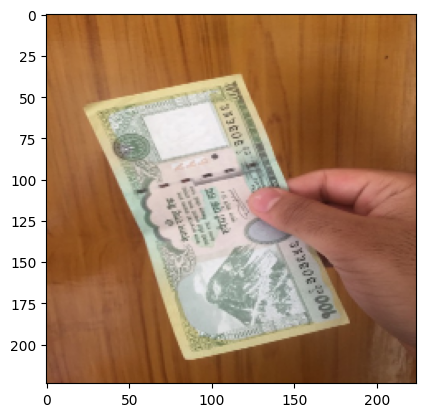

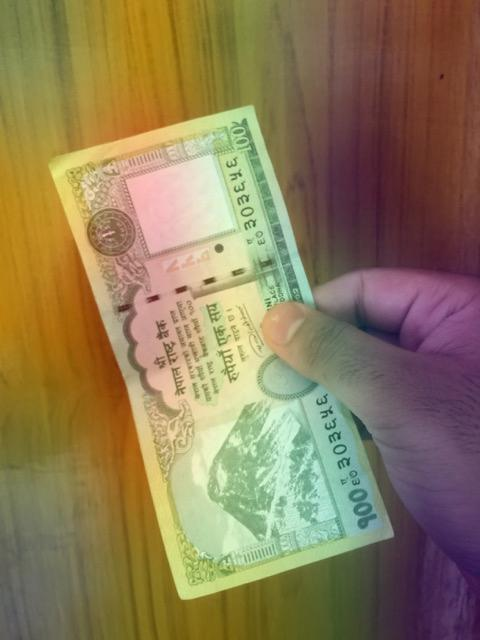

In [10]:
import cv2
img_path = '/kaggle/input/nepali-currency-data/test/hundred/hundred_test_113.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(SIZE,SIZE))
img_array = np.array(img).reshape(1,SIZE,SIZE,3)

last_conv_layer_name = 'conv2d'

model.layers[-1].activation = None
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

plt.imshow(img)
plt.show()
display_gradcam(img_path, heatmap,  alpha=0.3)


## Model evaluation

22/22 [==============================] - 13s 381ms/step


<Axes: >

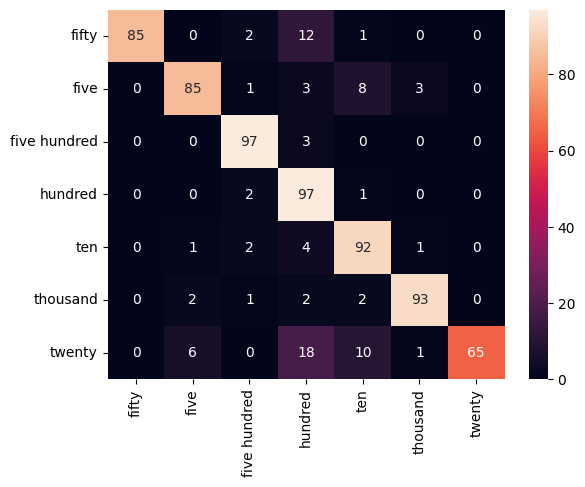

In [11]:
images,labels = next(iter(test_set))

predicted = model.predict(images)
true_labels = np.argmax(labels,axis = 1)
predicted_labels = np.argmax(predicted, axis = 1)

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix = confusion_matrix(true_labels,predicted_labels)
sns.heatmap(confusion_matrix,annot = True,fmt = 'd',yticklabels = classes,xticklabels = classes)


In [12]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       100
           1       0.90      0.85      0.88       100
           2       0.92      0.97      0.95       100
           3       0.70      0.97      0.81       100
           4       0.81      0.92      0.86       100
           5       0.95      0.93      0.94       100
           6       1.00      0.65      0.79       100

    accuracy                           0.88       700
   macro avg       0.90      0.88      0.88       700
weighted avg       0.90      0.88      0.88       700

